In [1]:
# importing python utility libraries
import os, sys, random, io, urllib
from datetime import datetime

# importing pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

# importing python plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
from IPython.display import Image, display

# Load Dataset

In [2]:
# load the synthetic ERP dataset
ori_dataset = pd.read_csv('./data/fraud_dataset_v2.csv')

# remove the "ground-truth" label information for the following steps of the lab
label = ori_dataset.pop('label')

# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'BUKRS', 'WAERS']

# encode categorical attributes into a binary one-hot encoded representation 
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])

# select "DMBTR" vs. "WRBTR" attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-4
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr], axis = 1)

# inspect final dimensions of pre-processed transactional data
ori_subset_transformed.shape

(533009, 618)

# Load Model Structure

In [3]:
# define encoder class
class Encoder(nn.Module):

    # define class constructor
    def __init__(self, input_size, hidden_size):

        # call super class constructor
        super(Encoder, self).__init__()

        # specify first layer - in 618, out 256
        self.map_L1 = nn.Linear(input_size, hidden_size[0], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 256, out 64
        self.map_L2 = nn.Linear(hidden_size[0], hidden_size[1], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 64, out 16
        self.map_L3 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fourth layer - in 16, out 4
        self.map_L4 = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_R4 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        '''
        # specify fifth layer - in 4, out 2
        self.map_L5 = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_L5.weight)
        nn.init.constant_(self.map_L5.bias, 0.0)
        self.map_R5 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)
        '''
        
        # define forward layer for mu and var
        self.map_mu = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_mu.weight)
        nn.init.constant_(self.map_mu.weight, 0.0)
        self.map_var = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_var.weight)
        nn.init.constant_(self.map_var.weight, 0.0)        
        
        
    # define reparameterize method
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_R4(self.map_L4(x))
        #x = self.map_R5(self.map_L5(x))
        
        # Calculate mu, logvar and pass to reparameterize method
        mu, logvar = self.map_mu(x), self.map_var(x)
        z = self.reparameterize(mu, logvar)
        
        # return result
        return z, mu, logvar


# define decoder class
class Decoder(nn.Module):

    # define class constructor
    def __init__(self, output_size, hidden_size):

        # call super class constructor
        super(Decoder, self).__init__()

        # specify first layer - in 2, out 4
        self.map_L1 = nn.Linear(hidden_size[0], hidden_size[1], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 4, out 16
        self.map_L2 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 16, out 64
        self.map_L3 = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fourth layer - in 64, out 256
        self.map_L4 = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify fifth layer - in 256, out 618
        self.map_L5 = nn.Linear(hidden_size[4], output_size, bias=True)
        nn.init.xavier_uniform_(self.map_L5.weight)
        nn.init.constant_(self.map_L5.bias, 0.0)
        self.map_S5 = torch.nn.Sigmoid()

    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_R4(self.map_L4(x))
        x = self.map_S5(self.map_L5(x))

        # return result
        return x


# define discriminator class
class Discriminator(nn.Module):

    # define class constructor
    def __init__(self, input_size, hidden_size, output_size):

        # call super class constructor
        super(Discriminator, self).__init__()

        # specify first layer - in 2, out 256
        self.map_L1 = nn.Linear(input_size, hidden_size[0], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 256, out 16
        self.map_L2 = nn.Linear(hidden_size[0], hidden_size[1], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 16, out 4
        self.map_L3 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify fourth layer - in 4, out 2
        self.map_L4 = nn.Linear(hidden_size[2], output_size, bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_S4 = torch.nn.Sigmoid()

    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_S4(self.map_L4(x))

        # return result
        return x


## Run Only One time

In [4]:
import os

for dirpath, dirnames, filenames in os.walk("./models/"):
    for file in filenames:
        filename = dirpath+file
        tmp = file.split("ep_")[-1]
        tmp = 'ep_' + tmp
        print(tmp)
        oldfilename = dirpath+file
        newfilename = dirpath+tmp
        os.rename(oldfilename, newfilename)

ep_3313_encoder_model.pth
ep_2419_discriminator_model.pth
ep_4645_discriminator_model.pth
ep_466_decoder_model.pth
ep_1600_encoder_model.pth
ep_4430_decoder_model.pth
ep_2111_encoder_model.pth
ep_3489_encoder_model.pth
ep_3810_decoder_model.pth
ep_3707_discriminator_model.pth
ep_52_encoder_model.pth
ep_718_encoder_model.pth
ep_2115_discriminator_model.pth
ep_4349_discriminator_model.pth
ep_406_discriminator_model.pth
ep_3993_encoder_model.pth
ep_1019_decoder_model.pth
ep_1864_decoder_model.pth
ep_1774_discriminator_model.pth
ep_4229_encoder_model.pth
ep_2708_decoder_model.pth
ep_4482_discriminator_model.pth
ep_3290_decoder_model.pth
ep_3674_encoder_model.pth
ep_101_decoder_model.pth
ep_1783_decoder_model.pth
ep_1367_encoder_model.pth
ep_4157_decoder_model.pth
ep_2476_encoder_model.pth
ep_1278_discriminator_model.pth
ep_2092_decoder_model.pth
ep_428_decoder_model.pth
ep_3477_discriminator_model.pth
ep_776_discriminator_model.pth
ep_2840_discriminator_model.pth
ep_2922_encoder_model.pth


ep_730_encoder_model.pth
ep_1812_discriminator_model.pth
ep_1237_discriminator_model.pth
ep_3083_discriminator_model.pth
ep_3045_decoder_model.pth
ep_3838_decoder_model.pth
ep_3488_decoder_model.pth
ep_3811_encoder_model.pth
ep_53_decoder_model.pth
ep_3513_discriminator_model.pth
ep_719_decoder_model.pth
ep_2924_discriminator_model.pth
ep_612_discriminator_model.pth
ep_2301_discriminator_model.pth
ep_3312_decoder_model.pth
ep_4451_discriminator_model.pth
ep_467_encoder_model.pth
ep_1601_decoder_model.pth
ep_4431_encoder_model.pth
ep_2110_decoder_model.pth
ep_3291_encoder_model.pth
ep_3675_decoder_model.pth
ep_100_encoder_model.pth
ep_4696_discriminator_model.pth
ep_1782_encoder_model.pth
ep_1366_decoder_model.pth
ep_4156_encoder_model.pth
ep_2477_decoder_model.pth
ep_2093_encoder_model.pth
ep_1560_discriminator_model.pth
ep_3992_decoder_model.pth
ep_1018_encoder_model.pth
ep_1865_encoder_model.pth
ep_4228_decoder_model.pth
ep_2709_encoder_model.pth
ep_1531_encoder_model.pth
ep_757_deco

ep_1418_discriminator_model.pth
ep_1188_discriminator_model.pth
ep_2243_encoder_model.pth
ep_4386_encoder_model.pth
ep_4762_decoder_model.pth
ep_3919_discriminator_model.pth
ep_1552_encoder_model.pth
ep_734_decoder_model.pth
ep_3041_encoder_model.pth
ep_4772_discriminator_model.pth
ep_2022_discriminator_model.pth
ep_2940_decoder_model.pth
ep_531_discriminator_model.pth
ep_4885_decoder_model.pth
ep_1484_discriminator_model.pth
ep_3630_discriminator_model.pth
ep_4906_encoder_model.pth
ep_950_encoder_model.pth
ep_3658_decoder_model.pth
ep_1643_discriminator_model.pth
ep_2724_encoder_model.pth
ep_60_discriminator_model.pth
ep_4205_decoder_model.pth
ep_1035_encoder_model.pth
ep_1848_encoder_model.pth
ep_253_decoder_model.pth
ep_3526_encoder_model.pth
ep_641_discriminator_model.pth
ep_2977_discriminator_model.pth
ep_2352_discriminator_model.pth
ep_3872_encoder_model.pth
ep_30_decoder_model.pth
ep_3540_discriminator_model.pth
ep_1985_decoder_model.pth
ep_4452_encoder_model.pth
ep_2173_decoder

ep_683_encoder_model.pth
ep_267_decoder_model.pth
ep_3090_discriminator_model.pth
ep_1224_discriminator_model.pth
ep_3512_encoder_model.pth
ep_1801_discriminator_model.pth
ep_2682_discriminator_model.pth
ep_2710_encoder_model.pth
ep_4231_decoder_model.pth
ep_391_discriminator_model.pth
ep_119_encoder_model.pth
ep_964_encoder_model.pth
ep_3288_encoder_model.pth
ep_1728_discriminator_model.pth
ep_4932_encoder_model.pth
ep_4315_discriminator_model.pth
ep_1618_decoder_model.pth
ep_4930_discriminator_model.pth
ep_2149_discriminator_model.pth
ep_2974_decoder_model.pth
ep_2109_decoder_model.pth
ep_4428_encoder_model.pth
ep_3872_discriminator_model.pth
ep_1566_encoder_model.pth
ep_1182_decoder_model.pth
ep_700_decoder_model.pth
ep_3075_encoder_model.pth
ep_3491_decoder_model.pth
ep_3257_discriminator_model.pth
ep_3808_encoder_model.pth
ep_4619_discriminator_model.pth
ep_2693_decoder_model.pth
ep_2277_encoder_model.pth
ep_156_discriminator_model.pth
ep_2445_discriminator_model.pth
ep_4756_decod

ep_518_discriminator_model.pth
ep_166_decoder_model.pth
ep_582_encoder_model.pth
ep_1300_encoder_model.pth
ep_3613_encoder_model.pth
ep_4090_discriminator_model.pth
ep_2411_encoder_model.pth
ep_2888_decoder_model.pth
ep_4130_decoder_model.pth
ep_1803_decoder_model.pth
ep_218_encoder_model.pth
ep_3189_encoder_model.pth
ep_1943_discriminator_model.pth
ep_49_discriminator_model.pth
ep_1366_discriminator_model.pth
ep_4267_decoder_model.pth
ep_4683_encoder_model.pth
ep_3442_discriminator_model.pth
ep_2746_encoder_model.pth
ep_3544_encoder_model.pth
ep_743_discriminator_model.pth
ep_2875_discriminator_model.pth
ep_2250_discriminator_model.pth
ep_1057_encoder_model.pth
ep_231_decoder_model.pth
ep_4500_discriminator_model.pth
ep_4964_encoder_model.pth
ep_4119_encoder_model.pth
ep_2438_decoder_model.pth
ep_932_encoder_model.pth
ep_1329_decoder_model.pth
ep_2922_decoder_model.pth
ep_3389_discriminator_model.pth
ep_428_encoder_model.pth
ep_4700_decoder_model.pth
ep_3685_discriminator_model.pth
ep

ep_1183_discriminator_model.pth
ep_1231_encoder_model.pth
ep_4275_discriminator_model.pth
ep_2029_discriminator_model.pth
ep_87_decoder_model.pth
ep_1932_decoder_model.pth
ep_4850_discriminator_model.pth
ep_329_encoder_model.pth
ep_4618_encoder_model.pth
ep_1648_discriminator_model.pth
ep_2339_decoder_model.pth
ep_3946_decoder_model.pth
ep_1428_decoder_model.pth
ep_4182_encoder_model.pth
ep_4566_decoder_model.pth
ep_2047_encoder_model.pth
ep_1344_discriminator_model.pth
ep_3245_encoder_model.pth
ep_530_decoder_model.pth
ep_1756_encoder_model.pth
ep_1961_discriminator_model.pth
ep_3973_encoder_model.pth
ep_3783_discriminator_model.pth
ep_1537_discriminator_model.pth
ep_1884_decoder_model.pth
ep_2191_discriminator_model.pth
ep_482_discriminator_model.pth
ep_3270_decoder_model.pth
ep_3694_encoder_model.pth
ep_505_encoder_model.pth
ep_1763_decoder_model.pth
ep_1387_encoder_model.pth
ep_4553_encoder_model.pth
ep_2496_encoder_model.pth
ep_2072_decoder_model.pth
ep_349_discriminator_model.pth

ep_4080_discriminator_model.pth
ep_3072_encoder_model.pth
ep_3496_decoder_model.pth
ep_2973_decoder_model.pth
ep_59_discriminator_model.pth
ep_1376_discriminator_model.pth
ep_479_encoder_model.pth
ep_1953_discriminator_model.pth
ep_3452_discriminator_model.pth
ep_3325_encoder_model.pth
ep_450_decoder_model.pth
ep_1636_encoder_model.pth
ep_2240_discriminator_model.pth
ep_4406_decoder_model.pth
ep_753_discriminator_model.pth
ep_2865_discriminator_model.pth
ep_2127_encoder_model.pth
ep_3826_decoder_model.pth
ep_1548_decoder_model.pth
ep_64_encoder_model.pth
ep_4510_discriminator_model.pth
ep_4778_encoder_model.pth
ep_2259_decoder_model.pth
ep_1852_decoder_model.pth
ep_249_encoder_model.pth
ep_3399_discriminator_model.pth
ep_3642_encoder_model.pth
ep_3695_discriminator_model.pth
ep_1421_discriminator_model.pth
ep_137_decoder_model.pth
ep_1351_encoder_model.pth
ep_4585_encoder_model.pth
ep_4161_decoder_model.pth
ep_594_discriminator_model.pth
ep_2440_encoder_model.pth
ep_2087_discriminator_

ep_1503_decoder_model.pth
ep_588_discriminator_model.pth
ep_381_decoder_model.pth
ep_765_encoder_model.pth
ep_3010_decoder_model.pth
ep_2212_decoder_model.pth
ep_3689_discriminator_model.pth
ep_4733_encoder_model.pth
ep_3817_discriminator_model.pth
ep_3539_decoder_model.pth
ep_1086_discriminator_model.pth
ep_3232_discriminator_model.pth
ep_1857_decoder_model.pth
ep_133_discriminator_model.pth
ep_2420_discriminator_model.pth
ep_4370_discriminator_model.pth
ep_3647_encoder_model.pth
ep_4955_discriminator_model.pth
ep_132_decoder_model.pth
ep_1354_encoder_model.pth
ep_4164_decoder_model.pth
ep_4580_encoder_model.pth
ep_4919_decoder_model.pth
ep_2445_encoder_model.pth
ep_3320_encoder_model.pth
ep_455_decoder_model.pth
ep_1633_encoder_model.pth
ep_4403_decoder_model.pth
ep_2122_encoder_model.pth
ep_3823_decoder_model.pth
ep_1241_discriminator_model.pth
ep_61_encoder_model.pth
ep_1864_discriminator_model.pth
ep_4399_decoder_model.pth
ep_900_encoder_model.pth
ep_3973_discriminator_model.pth
e

ep_4555_decoder_model.pth
ep_4869_discriminator_model.pth
ep_2809_encoder_model.pth
ep_2490_decoder_model.pth
ep_2074_encoder_model.pth
ep_503_discriminator_model.pth
ep_3276_encoder_model.pth
ep_3692_decoder_model.pth
ep_3602_discriminator_model.pth
ep_503_decoder_model.pth
ep_1765_encoder_model.pth
ep_1381_decoder_model.pth
ep_4032_decoder_model.pth
ep_2513_encoder_model.pth
ep_3711_encoder_model.pth
ep_480_encoder_model.pth
ep_1671_discriminator_model.pth
ep_819_decoder_model.pth
ep_1202_encoder_model.pth
ep_1958_discriminator_model.pth
ep_52_discriminator_model.pth
ep_2289_encoder_model.pth
ep_4587_discriminator_model.pth
ep_1598_encoder_model.pth
ep_1901_decoder_model.pth
ep_2945_discriminator_model.pth
ep_2344_decoder_model.pth
ep_673_discriminator_model.pth
ep_4665_encoder_model.pth
ep_4281_decoder_model.pth
ep_2360_discriminator_model.pth
ep_1455_decoder_model.pth
ep_633_encoder_model.pth
ep_3572_discriminator_model.pth
ep_3146_decoder_model.pth
ep_2847_encoder_model.pth
ep_498

ep_3592_decoder_model.pth
ep_1512_discriminator_model.pth
ep_2790_decoder_model.pth
ep_2374_encoder_model.pth
ep_4655_decoder_model.pth
ep_199_decoder_model.pth
ep_3208_decoder_model.pth
ep_2877_decoder_model.pth
ep_867_encoder_model.pth
ep_949_discriminator_model.pth
ep_1698_encoder_model.pth
ep_4423_discriminator_model.pth
ep_2189_encoder_model.pth
ep_4831_encoder_model.pth
ep_1102_encoder_model.pth
ep_780_encoder_model.pth
ep_364_decoder_model.pth
ep_3561_discriminator_model.pth
ep_3888_decoder_model.pth
ep_3411_encoder_model.pth
ep_2373_discriminator_model.pth
ep_2613_encoder_model.pth
ep_4332_decoder_model.pth
ep_660_discriminator_model.pth
ep_2956_discriminator_model.pth
ep_4385_encoder_model.pth
ep_4761_decoder_model.pth
ep_1975_discriminator_model.pth
ep_1350_discriminator_model.pth
ep_2240_encoder_model.pth
ep_3042_encoder_model.pth
ep_1551_encoder_model.pth
ep_737_decoder_model.pth
ep_4886_decoder_model.pth
ep_2943_decoder_model.pth
ep_449_encoder_model.pth
ep_4178_encoder_mo

ep_323_discriminator_model.pth
ep_3022_discriminator_model.pth
ep_1296_discriminator_model.pth
ep_3923_encoder_model.pth
ep_4503_encoder_model.pth
ep_2022_decoder_model.pth
ep_3220_decoder_model.pth
ep_4160_discriminator_model.pth
ep_555_encoder_model.pth
ep_1733_decoder_model.pth
ep_2919_discriminator_model.pth
ep_2992_encoder_model.pth
ep_2787_discriminator_model.pth
ep_4857_encoder_model.pth
ep_294_discriminator_model.pth
ep_498_decoder_model.pth
ep_801_encoder_model.pth
ep_1321_discriminator_model.pth
ep_3195_discriminator_model.pth
ep_1904_discriminator_model.pth
ep_3709_decoder_model.pth
ep_3499_discriminator_model.pth
ep_2675_encoder_model.pth
ep_2291_decoder_model.pth
ep_4354_decoder_model.pth
ep_1580_decoder_model.pth
ep_1164_encoder_model.pth
ep_1919_encoder_model.pth
ep_302_decoder_model.pth
ep_3093_decoder_model.pth
ep_3477_encoder_model.pth
ep_798_discriminator_model.pth
ep_2312_encoder_model.pth
ep_4633_decoder_model.pth
ep_4210_discriminator_model.pth
ep_1403_encoder_mod

ep_1194_decoder_model.pth
ep_3063_encoder_model.pth
ep_3487_decoder_model.pth
ep_2233_discriminator_model.pth
ep_2962_decoder_model.pth
ep_4563_discriminator_model.pth
ep_809_discriminator_model.pth
ep_468_encoder_model.pth
ep_1399_discriminator_model.pth
ep_2478_decoder_model.pth
ep_4924_encoder_model.pth
ep_4159_encoder_model.pth
ep_1369_decoder_model.pth
ep_972_encoder_model.pth
ep_1452_discriminator_model.pth
ep_2706_encoder_model.pth
ep_4227_decoder_model.pth
ep_695_encoder_model.pth
ep_271_decoder_model.pth
ep_1017_encoder_model.pth
ep_3504_encoder_model.pth
ep_3846_discriminator_model.pth
ep_3157_encoder_model.pth
ep_622_decoder_model.pth
ep_3263_discriminator_model.pth
ep_1444_encoder_model.pth
ep_4290_encoder_model.pth
ep_4674_decoder_model.pth
ep_162_discriminator_model.pth
ep_2471_discriminator_model.pth
ep_2355_encoder_model.pth
ep_4321_discriminator_model.pth
ep_3229_decoder_model.pth
ep_4904_discriminator_model.pth
ep_4993_decoder_model.pth
ep_2856_decoder_model.pth
ep_84

ep_2703_encoder_model.pth
ep_4926_discriminator_model.pth
ep_4222_decoder_model.pth
ep_4303_discriminator_model.pth
ep_274_decoder_model.pth
ep_690_encoder_model.pth
ep_1012_encoder_model.pth
ep_3998_decoder_model.pth
ep_3501_encoder_model.pth
ep_2264_encoder_model.pth
ep_2680_decoder_model.pth
ep_2398_discriminator_model.pth
ep_4745_decoder_model.pth
ep_59_decoder_model.pth
ep_713_decoder_model.pth
ep_1191_decoder_model.pth
ep_1575_encoder_model.pth
ep_3482_decoder_model.pth
ep_3066_encoder_model.pth
ep_1817_discriminator_model.pth
ep_2967_decoder_model.pth
ep_1232_discriminator_model.pth
ep_3086_discriminator_model.pth
ep_387_discriminator_model.pth
ep_3318_decoder_model.pth
ep_2694_discriminator_model.pth
ep_4073_discriminator_model.pth
ep_4112_encoder_model.pth
ep_2433_decoder_model.pth
ep_3631_decoder_model.pth
ep_1689_discriminator_model.pth
ep_1322_decoder_model.pth
ep_144_encoder_model.pth
ep_939_encoder_model.pth
ep_4688_encoder_model.pth
ep_3131_discriminator_model.pth
ep_138

ep_322_decoder_model.pth
ep_1939_encoder_model.pth
ep_1144_encoder_model.pth
ep_2881_discriminator_model.pth
ep_3457_encoder_model.pth
ep_2655_encoder_model.pth
ep_1602_discriminator_model.pth
ep_4790_encoder_model.pth
ep_4374_decoder_model.pth
ep_821_encoder_model.pth
ep_21_discriminator_model.pth
ep_3729_decoder_model.pth
ep_4877_encoder_model.pth
ep_4023_decoder_model.pth
ep_2238_discriminator_model.pth
ep_4064_discriminator_model.pth
ep_2502_encoder_model.pth
ep_3700_encoder_model.pth
ep_1213_encoder_model.pth
ep_808_decoder_model.pth
ep_491_encoder_model.pth
ep_1392_discriminator_model.pth
ep_3126_discriminator_model.pth
ep_2298_encoder_model.pth
ep_2734_discriminator_model.pth
ep_802_discriminator_model.pth
ep_1910_decoder_model.pth
ep_4568_discriminator_model.pth
ep_1589_encoder_model.pth
ep_227_discriminator_model.pth
ep_1155_discriminator_model.pth
ep_3964_decoder_model.pth
ep_3119_decoder_model.pth
ep_288_decoder_model.pth
ep_1893_encoder_model.pth
ep_4544_decoder_model.pth
e

ep_2350_decoder_model.pth
ep_4295_decoder_model.pth
ep_4671_encoder_model.pth
ep_627_encoder_model.pth
ep_1441_decoder_model.pth
ep_2224_discriminator_model.pth
ep_4078_discriminator_model.pth
ep_737_discriminator_model.pth
ep_2801_discriminator_model.pth
ep_3152_decoder_model.pth
ep_2728_discriminator_model.pth
ep_2853_encoder_model.pth
ep_4996_encoder_model.pth
ep_4574_discriminator_model.pth
ep_559_decoder_model.pth
ep_2549_encoder_model.pth
ep_4068_decoder_model.pth
ep_4815_decoder_model.pth
ep_1258_encoder_model.pth
ep_843_decoder_model.pth
ep_1149_discriminator_model.pth
ep_2637_decoder_model.pth
ep_1445_discriminator_model.pth
ep_4316_encoder_model.pth
ep_340_encoder_model.pth
ep_1126_decoder_model.pth
ep_3435_decoder_model.pth
ep_4604_discriminator_model.pth
ep_2458_discriminator_model.pth
ep_3961_decoder_model.pth
ep_669_encoder_model.pth
ep_1896_encoder_model.pth
ep_4541_decoder_model.pth
ep_2060_encoder_model.pth
ep_2484_decoder_model.pth
ep_3746_discriminator_model.pth
ep_3

ep_2083_decoder_model.pth
ep_3302_encoder_model.pth
ep_1611_encoder_model.pth
ep_477_decoder_model.pth
ep_4421_decoder_model.pth
ep_1050_discriminator_model.pth
ep_2100_encoder_model.pth
ep_3801_decoder_model.pth
ep_3498_encoder_model.pth
ep_43_encoder_model.pth
ep_709_encoder_model.pth
ep_4983_discriminator_model.pth
ep_220_encoder_model.pth
ep_1046_decoder_model.pth
ep_3555_decoder_model.pth
ep_2541_discriminator_model.pth
ep_2757_decoder_model.pth
ep_3976_discriminator_model.pth
ep_3353_discriminator_model.pth
ep_4692_decoder_model.pth
ep_4276_encoder_model.pth
ep_1338_encoder_model.pth
ep_923_decoder_model.pth
ep_4211_discriminator_model.pth
ep_2429_encoder_model.pth
ep_4834_discriminator_model.pth
ep_4108_decoder_model.pth
ep_4975_decoder_model.pth
ep_439_decoder_model.pth
ep_3498_discriminator_model.pth
ep_2933_encoder_model.pth
ep_799_discriminator_model.pth
ep_2786_discriminator_model.pth
ep_747_encoder_model.pth
ep_1521_decoder_model.pth
ep_295_discriminator_model.pth
ep_3032_

ep_3767_discriminator_model.pth
ep_4922_decoder_model.pth
ep_693_decoder_model.pth
ep_277_encoder_model.pth
ep_1011_decoder_model.pth
ep_3502_decoder_model.pth
ep_2700_decoder_model.pth
ep_2479_discriminator_model.pth
ep_4625_discriminator_model.pth
ep_4221_encoder_model.pth
ep_4296_decoder_model.pth
ep_4672_encoder_model.pth
ep_2353_decoder_model.pth
ep_3151_decoder_model.pth
ep_624_encoder_model.pth
ep_1442_decoder_model.pth
ep_4885_discriminator_model.pth
ep_4995_encoder_model.pth
ep_2850_encoder_model.pth
ep_1156_discriminator_model.pth
ep_801_discriminator_model.pth
ep_4816_decoder_model.pth
ep_2737_discriminator_model.pth
ep_224_discriminator_model.pth
ep_3748_encoder_model.pth
ep_3125_discriminator_model.pth
ep_1391_discriminator_model.pth
ep_840_decoder_model.pth
ep_3429_discriminator_model.pth
ep_4315_encoder_model.pth
ep_2634_decoder_model.pth
ep_3436_decoder_model.pth
ep_4067_discriminator_model.pth
ep_343_encoder_model.pth
ep_1125_decoder_model.pth
ep_728_discriminator_mode

ep_971_encoder_model.pth
ep_1386_discriminator_model.pth
ep_3132_discriminator_model.pth
ep_4224_decoder_model.pth
ep_2705_encoder_model.pth
ep_4070_discriminator_model.pth
ep_2809_discriminator_model.pth
ep_3507_encoder_model.pth
ep_696_encoder_model.pth
ep_272_decoder_model.pth
ep_1869_encoder_model.pth
ep_1014_encoder_model.pth
ep_1840_decoder_model.pth
ep_35_discriminator_model.pth
ep_1343_encoder_model.pth
ep_958_decoder_model.pth
ep_125_decoder_model.pth
ep_3650_encoder_model.pth
ep_1616_discriminator_model.pth
ep_2895_discriminator_model.pth
ep_2452_encoder_model.pth
ep_4597_encoder_model.pth
ep_4173_decoder_model.pth
ep_1624_encoder_model.pth
ep_3665_discriminator_model.pth
ep_442_decoder_model.pth
ep_3337_encoder_model.pth
ep_2077_discriminator_model.pth
ep_2135_encoder_model.pth
ep_2948_encoder_model.pth
ep_4414_decoder_model.pth
ep_564_discriminator_model.pth
ep_76_encoder_model.pth
ep_4727_discriminator_model.pth
ep_3834_decoder_model.pth
ep_3049_decoder_model.pth
ep_3369_d

ep_1822_encoder_model.pth
ep_2229_encoder_model.pth
ep_4708_decoder_model.pth
ep_1538_encoder_model.pth
ep_4560_discriminator_model.pth
ep_14_decoder_model.pth
ep_3856_encoder_model.pth
ep_2157_decoder_model.pth
ep_723_discriminator_model.pth
ep_2815_discriminator_model.pth
ep_4092_decoder_model.pth
ep_4476_encoder_model.pth
ep_2230_discriminator_model.pth
ep_1646_decoder_model.pth
ep_420_encoder_model.pth
ep_1696_discriminator_model.pth
ep_3422_discriminator_model.pth
ep_3355_decoder_model.pth
ep_3798_decoder_model.pth
ep_1923_discriminator_model.pth
ep_29_discriminator_model.pth
ep_409_decoder_model.pth
ep_1306_discriminator_model.pth
ep_890_encoder_model.pth
ep_896_discriminator_model.pth
ep_2903_encoder_model.pth
ep_3002_decoder_model.pth
ep_2889_discriminator_model.pth
ep_393_decoder_model.pth
ep_777_encoder_model.pth
ep_1511_decoder_model.pth
ep_1988_encoder_model.pth
ep_4721_encoder_model.pth
ep_2200_decoder_model.pth
ep_4812_discriminator_model.pth
ep_3565_decoder_model.pth
ep_

# Load Model

In [26]:
encoder_train = Encoder(input_size=ori_subset_transformed.shape[1], hidden_size=[256, 64, 16, 4, 2])
decoder_train = Decoder(output_size=ori_subset_transformed.shape[1], hidden_size=[2, 4, 16, 64, 256])

encoder_train.load_state_dict(torch.load("./models_VAEGAN_batch128/ep_2000_encoder_model.pth", map_location=torch.device('cpu')))
decoder_train.load_state_dict(torch.load("./models_VAEGAN_batch128/ep_2000_decoder_model.pth", map_location=torch.device('cpu')))
#discriminator_train.load_state_dict(torch.load("./models_VAEGAN_batch128/discriminator_model.pth", map_location=torch.device('cpu')))

encoder_eval = encoder_train
decoder_eval = decoder_train

# convert pre-processed data to pytorch tensor
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

# convert to pytorch tensor - none cuda enabled
dataloader_eval = DataLoader(torch_dataset, batch_size=131072, shuffle=False, num_workers=0)

# determine if CUDA is available at the compute node
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    
    # push dataloader to CUDA
    dataloader_eval = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=False)

# Latent Space Representation

## Imposed Latent Prior Distribution

In [27]:
# define the number of gaussians
tau = 5 

# define radius of each gaussian
radius = 0.8

# define the sigma of each gaussian
sigma = 0.01

# define the dimensionality of each gaussian
dim = 2

# determine x and y coordinates of the target mixture of gaussians
x_centroid = (radius * np.sin(np.linspace(0, 2 * np.pi, tau, endpoint=False)) + 1) / 2
y_centroid = (radius * np.cos(np.linspace(0, 2 * np.pi, tau, endpoint=False)) + 1) / 2

# determine each gaussians mean (centroid) and standard deviation
mu_gauss = np.vstack([x_centroid, y_centroid]).T

# determine the number of samples to be created per gaussian
samples_per_gaussian = 100000

# iterate over the number of distinct gaussians
for i, mu in enumerate(mu_gauss):

    # case: first gaussian
    if i == 0:

        # randomly sample from gaussion distribution 
        z_continous_samples_all = np.random.normal(mu, sigma, size=(samples_per_gaussian, dim))

    # case: non-first gaussian
    else:

        # randomly sample from gaussian distribution
        z_continous_samples = np.random.normal(mu, sigma, size=(samples_per_gaussian, dim))

        # collect and stack new samples
        z_continous_samples_all = np.vstack([z_continous_samples_all, z_continous_samples])

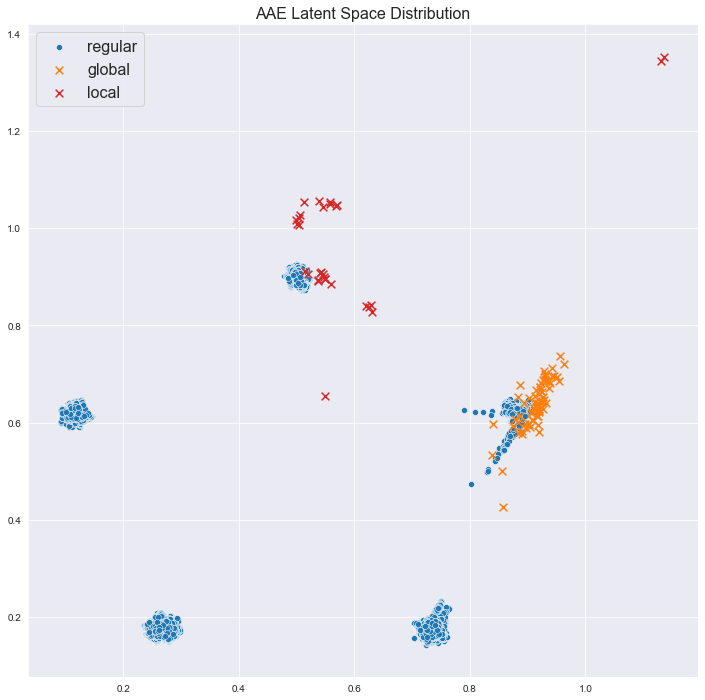

In [28]:
# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# init batch count
batch_count = 0

# iterate over epoch mini batches
for enc_transactions_batch in dataloader_eval:
    with torch.no_grad():
        # determine latent space representation of all transactions
        z_enc_transactions_batch, _, _ = encoder_eval(enc_transactions_batch)
        # case: initial batch 
        if batch_count == 0:

            # collect reconstruction errors of batch
            z_enc_transactions_all = z_enc_transactions_batch

        # case: non-initial batch
        else:
            # collect reconstruction errors of batch
            z_enc_transactions_all = torch.cat((z_enc_transactions_all, z_enc_transactions_batch), 0)
            
        # increase batch count
        batch_count += 1

# convert to numpy array
z_enc_transactions_all = z_enc_transactions_all.detach().numpy()

# prepare plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

# obtain regular transactions as well as global and local anomalies
regular_data = z_enc_transactions_all[label == 'regular']
global_outliers = z_enc_transactions_all[label == 'global']
local_outliers = z_enc_transactions_all[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', marker="o", label='regular', edgecolors='w', linewidth=0.5) # plot regular transactions
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="x", label='global', edgecolors='w', s=60) # plot global outliers
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C3', marker="x", label='local', edgecolors='w', s=60) # plot local outliers

# add plot legend of transaction classes
plt.title("AAE Latent Space Distribution", size=16)
ax.legend(loc='best', prop={'size': 16});

# Normalized Mode Divergence (MD) of Each Journal Entry

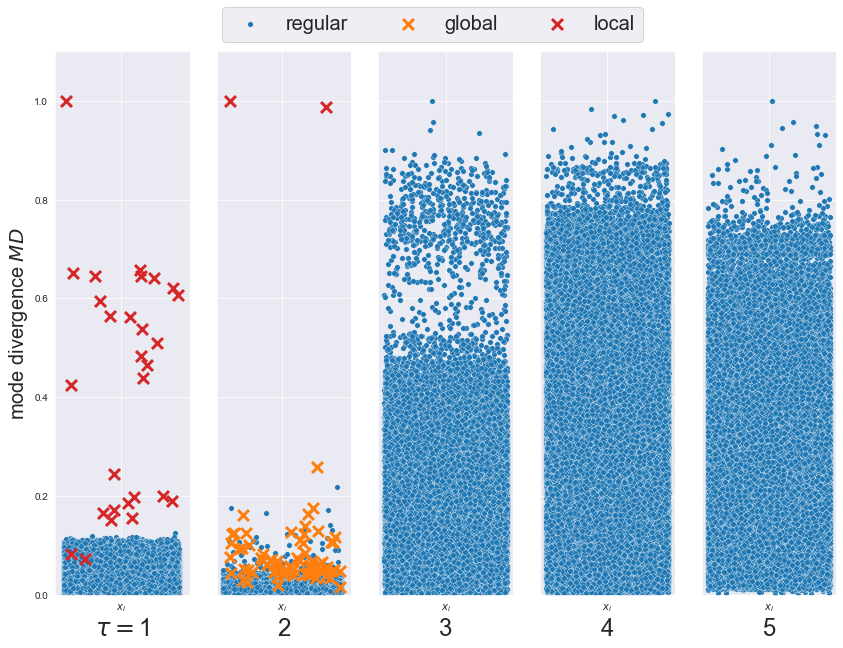

In [29]:
# define euclidean distance calculation
def compute_euclid_distance(x, y):
    
    # calculate euclidean distance 
    euclidean_distance = np.sqrt(np.sum((x - y) ** 2, axis=1))
    
    # return euclidean distance
    return euclidean_distance

# determine distance to each mode
distances = np.apply_along_axis(func1d=compute_euclid_distance, axis=1, arr=z_enc_transactions_all, y=mu_gauss)

# determine mode divergence
mode_divergence = np.min(distances, axis=1)

# determine min-mode id
cluster_ids = np.argmin(distances, axis=1)    

# normalize the mode divergences of each mode

# prepare empty arrays of the same shape and dtype
mode_divergence_all_scaled = np.asarray(mode_divergence)

# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id

    # normalize mode journal entries mode divergence to the range [0,1]
    mode_divergence_all_scaled[mask] = (mode_divergence[mask] - mode_divergence[mask].min()) / (mode_divergence[mask].ptp())   


# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(mode_divergence_all_scaled, name='mode_divergence'), 
                       pd.Series(label, name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))


# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['mode_divergence'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['mode_divergence'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['mode_divergence'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('mode divergence $MD$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)

# Normalized Reconstruction Error (RE) of Each Journal Entry

In [30]:
# define the optimization criterion / loss function
reconstruction_criterion_categorical_eval = nn.BCEWithLogitsLoss(reduction='none')
reconstruction_criterion_numeric_eval = nn.MSELoss(reduction='none')

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    reconstruction_criterion_categorical_eval = reconstruction_criterion_categorical_eval.cuda()
    reconstruction_criterion_numeric_eval = reconstruction_criterion_numeric_eval.cuda()

# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# init batch count
batch_count = 0

# iterate over epoch mini batches
for enc_transactions_batch in dataloader_eval:

    # determine latent space representation of all transactions
    z_enc_transactions_batch, _, _ = encoder_eval(enc_transactions_batch)

    # reconstruct input samples
    reconstruction_batch = decoder_eval(z_enc_transactions_batch)

    # split input transactions into numeric and categorical parts
    input_cat_all = enc_transactions_batch[:, :ori_dataset_categ_transformed.shape[1]]
    input_num_all = enc_transactions_batch[:, ori_dataset_categ_transformed.shape[1]:]

    # split reconstruction into numeric and categorical parts
    rec_cat_all = reconstruction_batch[:, :ori_dataset_categ_transformed.shape[1]]
    rec_num_all = reconstruction_batch[:, ori_dataset_categ_transformed.shape[1]:]

    # compute rec error
    rec_error_cat_all = reconstruction_criterion_categorical_eval(input=rec_cat_all, target=input_cat_all).mean(dim=1)
    rec_error_num_all = reconstruction_criterion_numeric_eval(input=rec_num_all, target=input_num_all).mean(dim=1)

    # combine categorical and numerical errors
    rec_error_all_batch = rec_error_cat_all + rec_error_num_all
    
    # case: initial batch
    if batch_count == 0:
    
      # collect reconstruction errors of batch
      rec_error_all = rec_error_all_batch
    
    # case: non-initial batch
    else:
      
      # collect reconstruction errors of batch
      rec_error_all = torch.cat((rec_error_all, rec_error_all_batch), dim=0)
    
    # increase batch count
    batch_count += 1

# convert to numpy array
rec_error_all = rec_error_all.cpu().detach().numpy()

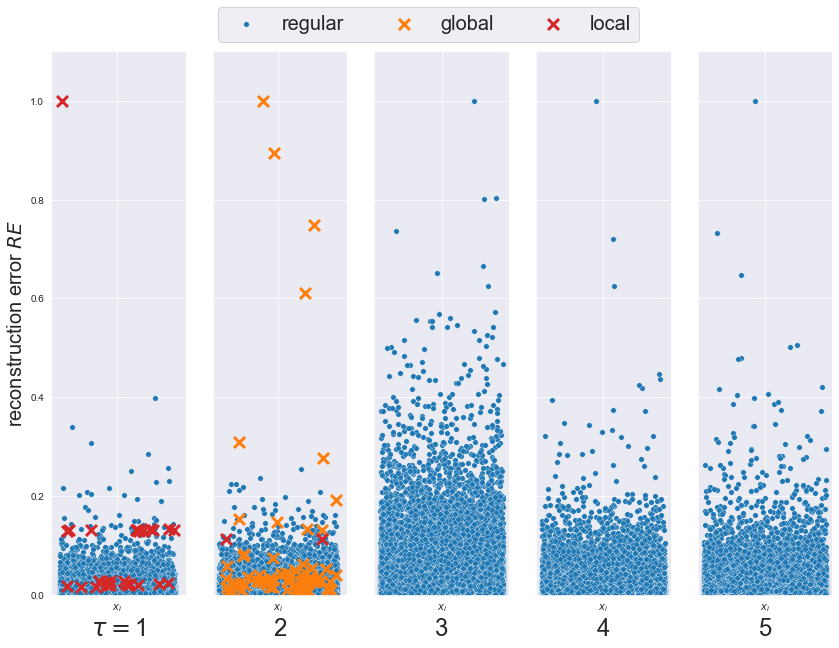

In [31]:
# normalize the reconstruction errors of each mode

# prepare empty arrays of the same shape and dtype
rec_error_all_scaled = np.asarray(rec_error_all)

# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id

    # normalize mode journal entries reconstruction error to the range [0,1]
    rec_error_all_scaled[mask] = (rec_error_all[mask] - rec_error_all[mask].min()) / (rec_error_all[mask].ptp())


# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(rec_error_all_scaled, name='rec_error'), 
                       pd.Series(label, name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))


# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['rec_error'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['rec_error'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['rec_error'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('reconstruction error $RE$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)

# Anomaly Score $AS^{\tau}$ of Each Journal Entry

In [32]:
# set alpha 
alpha = 0.4

# determine journal entry anomaly score
anomaly_score = alpha * rec_error_all_scaled + (1.0 - alpha) * mode_divergence_all_scaled

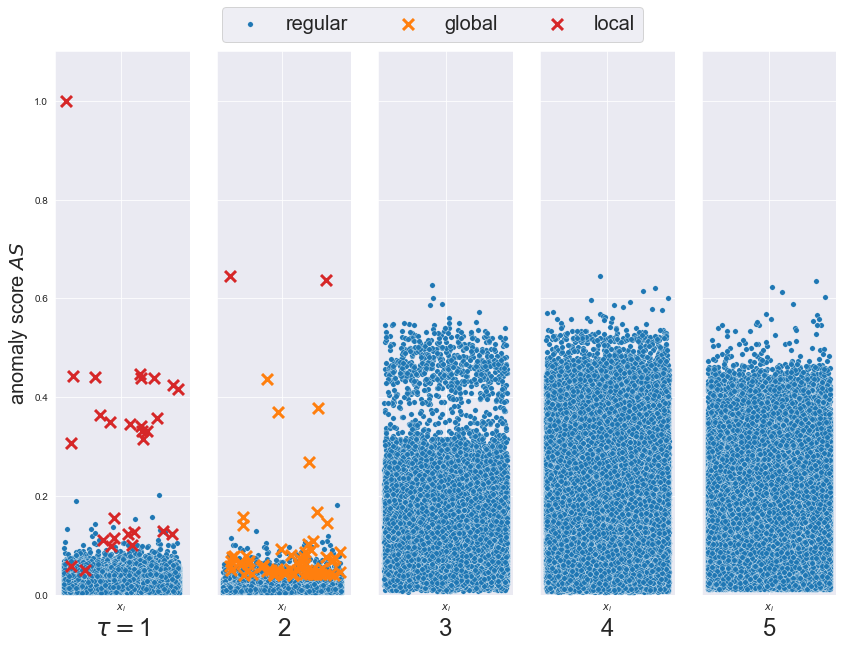

In [33]:

# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(anomaly_score, name='anomaly_score'), 
                       pd.Series(label, name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))

# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['anomaly_score'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['anomaly_score'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['anomaly_score'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('anomaly score $AS$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)

In [ ]:
ori_dataset['label'] = label
ori_dataset['tau'] = cluster_ids

# inspect transactions exhibiting a reconstruction error >= 0.2
ori_dataset[(anomaly_score >= 0.25) & (cluster_ids == 4)]

In [ ]:
# inspect transactions exhibiting a anomaly_score >= 0.4 from the mode 2
ori_dataset[(anomaly_score >= 0.4) & (cluster_ids == 1)]